Link Dataset: https://data.world/crowdflower/airline-twitter-sentiment

In [ ]:
pip install wordcloud

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing
import re
import nltk
import io
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Business Analytics/Airline-Sentiment.csv", encoding="latin-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,LABEL,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,Caption,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/2015 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,5.700000e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/2015 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,5.700000e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/2015 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,5.700000e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/2015 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,5.700000e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/2015 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,5.700000e+17,NaN,Pacific Time (US & Canada)


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   _unit_id                      14640 non-null  int64  
 1   _golden                       14640 non-null  bool   
 2   _unit_state                   14640 non-null  object 
 3   _trusted_judgments            14640 non-null  int64  
 4   _last_judgment_at             14584 non-null  object 
 5   LABEL                         14640 non-null  object 
 6   airline_sentiment:confidence  14640 non-null  float64
 7   negativereason                9178 non-null   object 
 8   negativereason:confidence     10522 non-null  float64
 9   airline                       14640 non-null  object 
 10  airline_sentiment_gold        40 non-null     object 
 11  name                          14640 non-null  object 
 12  negativereason_gold           32 non-null     object 
 13  r

In [ ]:
df.isna().sum()

,0
_unit_id,0
_golden,0
_unit_state,0
_trusted_judgments,0
_last_judgment_at,56
LABEL,0
airline_sentiment:confidence,0
negativereason,5462
negativereason:confidence,4118
airline,0


# Preprocessing

In [ ]:
df = df[['Caption', 'LABEL']].copy()

In [ ]:
# Distribusi Sentimen
value_counts = df['LABEL'].value_counts()
print('Value Count For: ', value_counts)

Value Count For:  LABEL
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


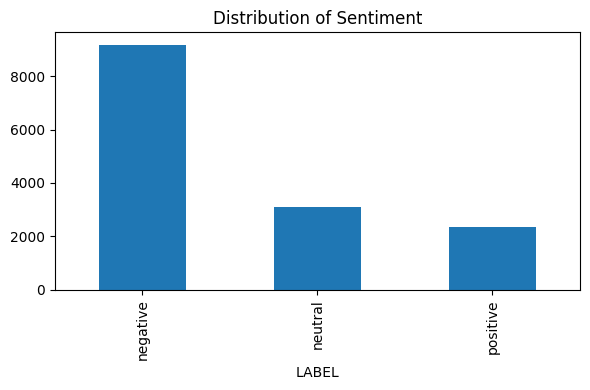

In [ ]:
# Plot Bar Chart
value_counts.plot(kind = 'bar',
                  title = 'Distribution of Sentiment',
                  figsize = (6, 4))
plt.tight_layout()
plt.show()

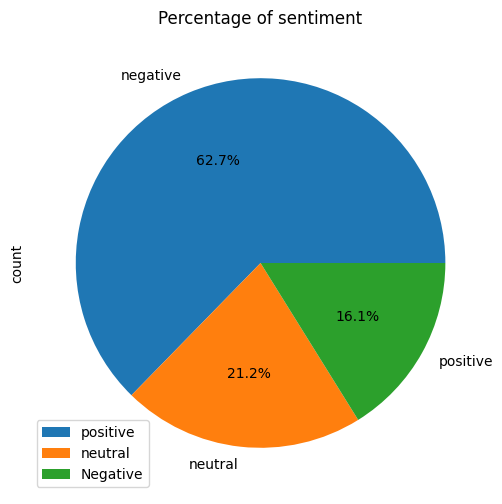

In [ ]:
# Plot Pie Chart
df['LABEL'].value_counts().plot.pie(figsize=(6,6),
                                    title="Percentage of sentiment",
                                    autopct='%1.1f%%')

# Labeling
labels=["positive","neutral", "Negative"]
plt.legend(labels, loc=3)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
df = df[df.LABEL != 'neutral'].copy()
df = df.reset_index(drop=True)
df.head()

,Caption,LABEL
0,@VirginAmerica plus you've added commercials t...,positive
1,@VirginAmerica it's really aggressive to blast...,negative
2,@VirginAmerica and it's a really big bad thing...,negative
3,@VirginAmerica seriously would pay $30 a fligh...,negative
4,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [ ]:
# Distribusi Sentimen
value_counts = df['LABEL'].value_counts()
print('Value Count For: ', value_counts)

Value Count For:  LABEL
negative    9178
positive    2363
Name: count, dtype: int64


In [ ]:
# Cleaning data
def remove(tweet):
  #remove mention
  tweet = re.sub("@[A-Za-z0-9_]+","", tweet)

  # remove stock market tickers like $GE
  tweet = re.sub(r'\$\w*', '', tweet)

  # remove old style retweet text "RT"
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'^rt[\s]+', '', tweet)

  # remove hyperlinks
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r'^https[\s]+', '', tweet)

  # remove hashtags
  # only removing the hash # sign from the word
  tweet = re.sub(r'#', '', tweet)
  tweet = re.sub(r'%', '', tweet)

  #remove comma
  tweet = re.sub(r',','',tweet)

  #remove number
  tweet = re.sub('[0-9]+', '', tweet)
  tweet = re.sub(r':', '', tweet)

  #remove space
  tweet = tweet.strip()

  #remove double space
  tweet = re.sub(r'\s+',' ',tweet)

  return tweet

df['cleaned_data'] = df['Caption'].apply(lambda x: remove(x.lower()))
df.head()

,Caption,LABEL,cleaned_data
0,@VirginAmerica plus you've added commercials t...,positive,plus you've added commercials to the experienc...
1,@VirginAmerica it's really aggressive to blast...,negative,"it's really aggressive to blast obnoxious ""ent..."
2,@VirginAmerica and it's a really big bad thing...,negative,and it's a really big bad thing about it
3,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay a flight for seats that di...
4,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time i fly vx this ûïear wor...


In [ ]:
# Drop duplicate data
df.drop_duplicates(subset ="cleaned_data", keep = 'first', inplace = True)
df.head()

,Caption,LABEL,cleaned_data
0,@VirginAmerica plus you've added commercials t...,positive,plus you've added commercials to the experienc...
1,@VirginAmerica it's really aggressive to blast...,negative,"it's really aggressive to blast obnoxious ""ent..."
2,@VirginAmerica and it's a really big bad thing...,negative,and it's a really big bad thing about it
3,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay a flight for seats that di...
4,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time i fly vx this ûïear wor...


In [ ]:
#clean stopwords
stopword = set(stopwords.words('english'))
stopword

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [ ]:
def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword) # hapus stopword dari kolom deskripsi
    return text

# Buat kolom tambahan untuk data description yang telah distopwordsremoval
df['tweet_sw'] = df['cleaned_data'].apply(clean_stopwords)
df.head()

,Caption,LABEL,cleaned_data,tweet_sw
0,@VirginAmerica plus you've added commercials t...,positive,plus you've added commercials to the experienc...,plus added commercials experience... tacky.
1,@VirginAmerica it's really aggressive to blast...,negative,"it's really aggressive to blast obnoxious ""ent...","really aggressive blast obnoxious ""entertainme..."
2,@VirginAmerica and it's a really big bad thing...,negative,and it's a really big bad thing about it,really big bad thing
3,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay a flight for seats that di...,seriously would pay flight seats playing. real...
4,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time i fly vx this ûïear wor...,yes nearly every time fly vx ûïear wormû wo...


In [ ]:
# Stemming
ps = PorterStemmer()
def porterstemmer(text):
  text = ' '.join(ps.stem(word) for word in text.split() if word in text)

  return text

df['tweet_stem'] = df['tweet_sw'].apply(porterstemmer)
df.head()

,Caption,LABEL,cleaned_data,tweet_sw,tweet_stem
0,@VirginAmerica plus you've added commercials t...,positive,plus you've added commercials to the experienc...,plus added commercials experience... tacky.,plu ad commerci experience... tacky.
1,@VirginAmerica it's really aggressive to blast...,negative,"it's really aggressive to blast obnoxious ""ent...","really aggressive blast obnoxious ""entertainme...","realli aggress blast obnoxi ""entertainment"" gu..."
2,@VirginAmerica and it's a really big bad thing...,negative,and it's a really big bad thing about it,really big bad thing,realli big bad thing
3,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay a flight for seats that di...,seriously would pay flight seats playing. real...,serious would pay flight seat playing. realli ...
4,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time i fly vx this ûïear wor...,yes nearly every time fly vx ûïear wormû wo...,ye nearli everi time fli vx ûïear wormû won...


In [ ]:
# Lemmatization
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
def lemmatization (text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]

    return ' '.join(tokens)

df['tweet_clean'] = df['tweet_stem'].apply(lemmatization)
df.head()

,Caption,LABEL,cleaned_data,tweet_sw,tweet_stem,tweet_clean
0,@VirginAmerica plus you've added commercials t...,positive,plus you've added commercials to the experienc...,plus added commercials experience... tacky.,plu ad commerci experience... tacky.,plu ad commerci experience tacky
1,@VirginAmerica it's really aggressive to blast...,negative,"it's really aggressive to blast obnoxious ""ent...","really aggressive blast obnoxious ""entertainme...","realli aggress blast obnoxi ""entertainment"" gu...",realli aggress blast obnoxi entertainment gues...
2,@VirginAmerica and it's a really big bad thing...,negative,and it's a really big bad thing about it,really big bad thing,realli big bad thing,realli big bad thing
3,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay a flight for seats that di...,seriously would pay flight seats playing. real...,serious would pay flight seat playing. realli ...,pay flight seat playing realli bad thing fli va
4,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time i fly vx this ûïear wor...,yes nearly every time fly vx ûïear wormû wo...,ye nearli everi time fli vx ûïear wormû won...,ye nearli everi time fli vx ûïear wormû won...


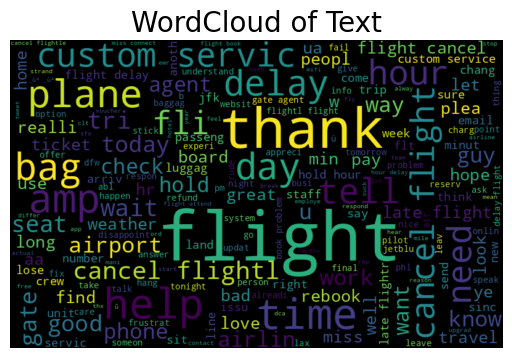

In [ ]:
# Buat WordCloud untuk memvisualisasikan kata-kata yang paling sering muncul
all_words = ' '.join([text for text in df['tweet_clean']])

wordcloud = WordCloud(
    width=800,
    height=500,
    random_state=21,
    max_font_size=110,
    background_color='black'
).generate(all_words)

# Plot WordCloud
plt.figure(figsize=(12, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud of Text', fontsize=20)
plt.show()

# TF-IDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['tweet_clean'])
vector = vectorizer.transform(df['tweet_clean'])

In [ ]:
pd.DataFrame(vector.todense())

,0,1,2,3,4,5,6,7,8,9,...,8424,8425,8426,8427,8428,8429,8430,8431,8432,8433
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(vector)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 88476 stored elements and shape (11301, 8434)>
  Coords	Values
  (0, 115)	0.3920438228238094
  (0, 1432)	0.4782416709232318
  (0, 2524)	0.3876874249241648
  (0, 5581)	0.3823396971158758
  (0, 7164)	0.5666580642179718
  (1, 171)	0.36647374515374054
  (1, 310)	0.16700585215302308
  (1, 824)	0.3435501599667215
  (1, 2378)	0.3435501599667215
  (1, 2564)	0.3005462143651371
  (1, 3214)	0.3435501599667215
  (1, 4247)	0.2576448046819923
  (1, 5097)	0.378258088334901
  (1, 5935)	0.20213526928710276
  (1, 5976)	0.378258088334901
  (2, 613)	0.41945478113084034
  (2, 786)	0.5668719352679799
  (2, 5935)	0.468082044067388
  (2, 7321)	0.5325533734882446
  (3, 613)	0.2554514018611847
  (3, 2743)	0.23906757953933844
  (3, 2746)	0.1307722401571467
  (3, 5402)	0.2793463437139113
  (3, 5554)	0.5568703201148161
  (3, 5935)	0.285065803805357
  :	:
  (11296, 7567)	0.3516360854561915
  (11297, 1720)	0.6442373054515761
  (11297, 1883)	0.672525401400

# Modeling

In [ ]:
X = df['tweet_clean']
y = df['LABEL']

X_train, X_test, y_train, y_test = train_test_split(vector, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(9040, 8434) (2261, 8434)


Baseline Model: Predict All as 'Positive'
Accuracy: 0.1924

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1826
    positive       0.19      1.00      0.32       435

    accuracy                           0.19      2261
   macro avg       0.10      0.50      0.16      2261
weighted avg       0.04      0.19      0.06      2261



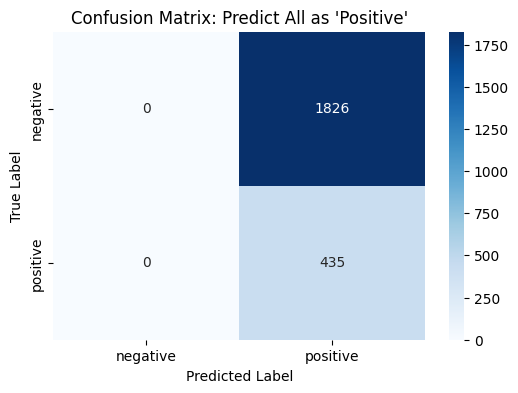

In [ ]:
MAJORITY_CLASS = 'positive'

y_pred_baseline = np.array([MAJORITY_CLASS] * len(y_test))

print("Baseline Model: Predict All as 'Positive'")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0))

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline, labels=['negative', 'positive'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title("Confusion Matrix: Predict All as 'Positive'")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

                 Model  Accuracy  Precision    Recall  F1-Score
0        Random Forest  0.893852   0.888520  0.893852  0.887722
1  Logistic Regression  0.885007   0.881674  0.885007  0.872343
2                  KNN  0.730650   0.733696  0.730650  0.732152


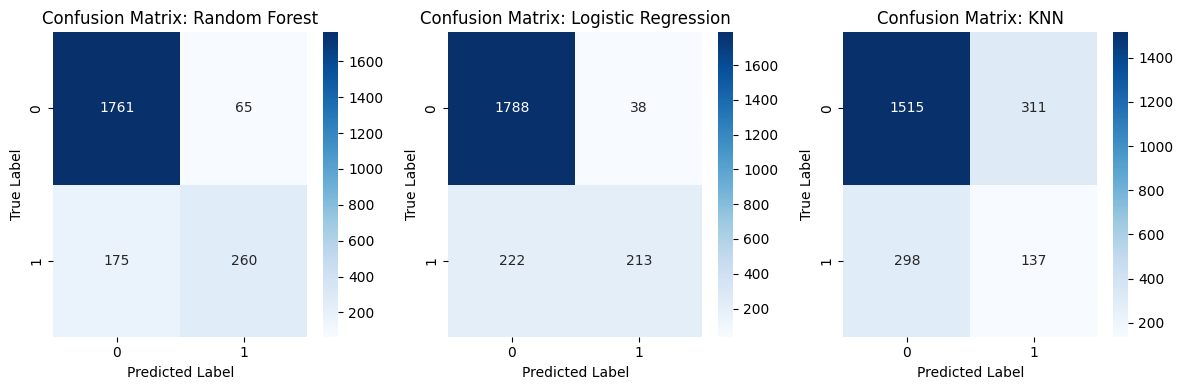

In [ ]:
# Dictionary model
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=0),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Evaluasi
evaluation_results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Menyimpan confusion matrix
conf_matrices = {}

# Train, evaluate, dan simpan confusion matrix
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    # Simpan ke tabel
    evaluation_results["Model"].append(name)
    evaluation_results["Accuracy"].append(acc)
    evaluation_results["Precision"].append(precision)
    evaluation_results["Recall"].append(recall)
    evaluation_results["F1-Score"].append(f1)

    # Simpan confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Convert ke DataFrame
results_df = pd.DataFrame(evaluation_results)
print(results_df)

# Plot Confusion Matrix
n_models = len(models)
fig_cols = 3
fig_rows = (n_models + 1) // fig_cols

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(12, 4 * fig_rows))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

for i in range(len(conf_matrices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Post-processing

In [ ]:
def preprocess_text(text):
    text = remove(text.lower())
    text = clean_stopwords(text)
    text = porterstemmer(text)
    text = lemmatization(text)
    return text

new_texts = [
    "I had a good day, the weather was beautiful and I loved the coffee!",
    "This is absolutely terrible, the service was so slow and the food was cold.",
    "The movie was just okay, nothing special but not bad either."
]

In [ ]:
# Model Random Forest yang di training
model_rf_trained = models["Random Forest"]

# Preprocessing pada Teks Baru
processed_texts = [preprocess_text(text) for text in new_texts]
new_vectors = vectorizer.transform(processed_texts)

# Prediksi Sentimen
predictions = model_rf_trained.predict(new_vectors)

print("Prediksi Sentimen")
for original_text, processed_text, prediction in zip(new_texts, processed_texts, predictions):
    print(f"\nOriginal: {original_text}")
    print(f"Processed: {processed_text}")
    print(f"Predicted Label: {prediction.upper()}")

Prediksi Sentimen

Original: I had a good day, the weather was beautiful and I loved the coffee!
Processed: good day weather beauti love coffee
Predicted Label: POSITIVE

Original: This is absolutely terrible, the service was so slow and the food was cold.
Processed: absolut terribl servic slow food cold
Predicted Label: NEGATIVE

Original: The movie was just okay, nothing special but not bad either.
Processed: movi okay noth special bad
Predicted Label: NEGATIVE
